2018 Edition<br>
<i>Luca LOMBARDO and Claudio SCALZO</i>

# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

# The dataset

### File descriptions

* train.csv - <i>the training dataset</i>
* test.csv - <i>the test dataset</i>
* data_description.txt - <i>full description of each column</i>

# Goal of the challenge

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

### Metric
Notebooks are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Submission File Format
The file should contain a header and have the following format:

```
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
```

You will find an example submission file within the data directory in the repository.

# Grading the notebook

This challenge is going to be graded as a regular notebook for the AML labs. As a consequence, students should submit:

* the html version of the notebook, using the Data Science Labs submission website, as usual [**Assignment: Challenge Notebook**]
* the submission file (in csv format), that we will use to rank students according to the metric defined above, again through the Data Science Labs submission website [**Assignment: Challenge Predictions**]

In summary, you will have to submit 2 files!

In [1]:
%%capture

# LIBRARIES IMPORT
# <-- installing external libraries -->
# pip install xgboost
# pip install bayesian-optimization

# <-- data manipulation and exploration--> 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import skew
from scipy import stats

# <-- plot -->
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import display, HTML, display_html

# <-- utilities -->
import random
from copy import deepcopy
from time import time
from datetime import datetime
import warnings

# <-- modeling -->
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import xgboost


%matplotlib inline

# FUNCTIONS
def compareSideBySide(*tables, index, header, title):
    htmlStr = "<br><p style='text-align: left'>" + title + "</p>"
    for table in tables:
        htmlStr += pd.DataFrame(data=table, columns=header, index=index).to_html(index=True)
    display_html(htmlStr.replace('<table','<table style="float:left; margin-right: 20px"'), raw=True)
    print()

# INITS
sns.set(style="whitegrid", palette="Greens_r", font_scale=1.3)

# 0. Preliminary operations and dataset import

In [2]:
# PATH AND FILES
basePath = "./challenge_data/"
trainFile = basePath + "train.csv"
testFile = basePath + "test.csv"

In [3]:
# LOAD THE TRAINSET AND THE DATASET
train = pd.read_csv(trainFile)
test = pd.read_csv(testFile)

# PRINT TO DESCRIBE
print("Houses:", train.shape[0])
print("Attributes:", train.shape[1] - 2, "(without considering the ID and the SalePrice)")
display(train.head(10))

Houses: 1200
Attributes: 79 (without considering the ID and the SalePrice)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


<div class='alert alert-success'>
The dataset is very small, only 1200 rows (houses) with 81 columns (79 attributes + ID + SalePrice). We considered useless, in this case, the use of a distributed computing framework like <i>Apache Spark</i>: we're going to do all of our work locally, exploiting libraries which work on a local fashion.
</div>

# 1. Descriptive statistics about the data

In [4]:
# ANALYZE ONLY THE NUMERICAL VALUES
numericalAttributes = train.select_dtypes(exclude="object").drop(columns="Id").columns.values

# COMPUTE SOME BASIC STATISTICS
print("Original numerical ('int64' and 'float64') attributes:", train[numericalAttributes].shape[1] - 1, "(without considering the SalePrice)")
display(train[numericalAttributes].describe())

Original numerical ('int64' and 'float64') attributes: 36 (without considering the SalePrice)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


<div class='alert alert-success'>
The numerical attributes (excluded the ID and the SalePrice) are 36. Of course the "numerical" word doesn't have the same meaning for all of them: we can find years, which of course represent different values than prices, areas, lengths or even categorical attributes encoded with numerical values. However, being each of them numerical, we computed this description thank to which we can see some basic statistics on our data. For example, we can immediately see that until the 75th percentile no houses have a pool: this can be useful for our model. We'll see later which attributes will impact more the model outcome.<br>
<br>
Before going ahead, let's analyze the <i>"object"</i> attributes:
</div>

In [5]:
# GET THE CATEGORICAL ATTRIBUTES
categoricalAttributes = train.select_dtypes(include="object").columns.values

# COMPUTE SOME BASIC STATISTICS
print("Original categorical ('object') attributes:", train[categoricalAttributes].shape[1])
display(train[categoricalAttributes].describe())

Original categorical ('object') attributes: 43


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,75,1200,1200,1200,1200,1200,1200,1200,...,1133,1133,1133,1133,1200,4,227,47,1200,1200
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,946,1194,41,754,1079,1199,862,1135,179,1035,...,718,500,1081,1093,1107,2,130,44,1036,979


<div class='alert alert-success'>
For the <i>"object"</i> attributes of course we can't compute means, maxs or percentiles: they are not numeric values! However other kind of statistics can be computed: we can see for example that each attribute doesn't have the same count. Maybe there is something wrong or missing, we are going to investigate about it in the next section.<br>
<br>
Now, let's concentrate on out target variable: <i>SalePrice</i>.
</div>

## <span style='color:#333333'>1.1 Target variable</span>

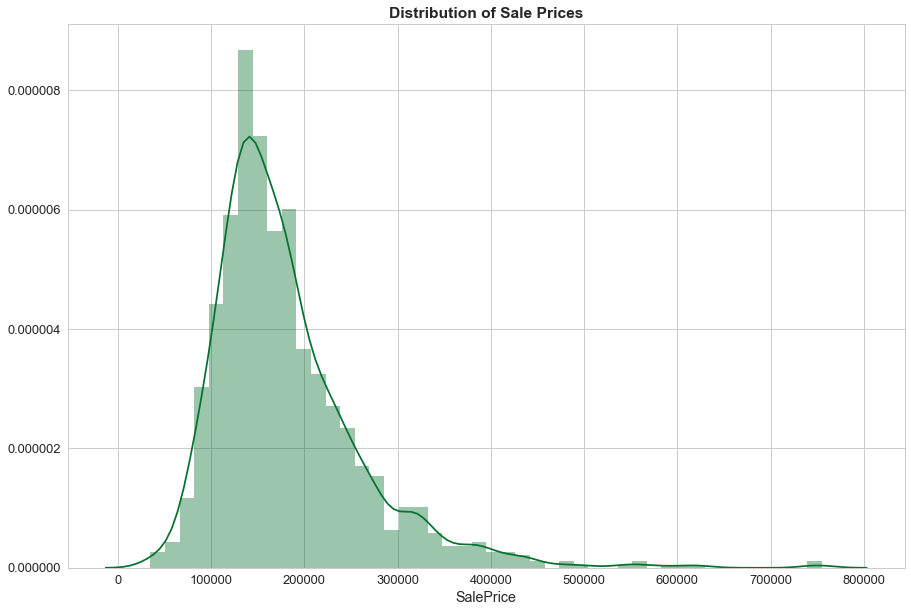

In [6]:
plt.figure(figsize=(15,10))
sns.distplot(train["SalePrice"])
plt.title("Distribution of Sale Prices", weight="semibold");

<div class='alert alert-success'>
We can see that is very frequent that our <i>SalePrice</i> has a value between <i>100'000&dollar;</i> and <i>200'000&dollar;</i>. The distribution is not symmetric but it's left-skewed, with a short tail on the left and a long tail on the right: this could lead (or maybe not) to some difficulties for our model. We'll investigate and deepen this aspect in the data pre-processing phase.<br>
<br>
Now let's take a look at the probability plot (to measure the skewness):
</div>

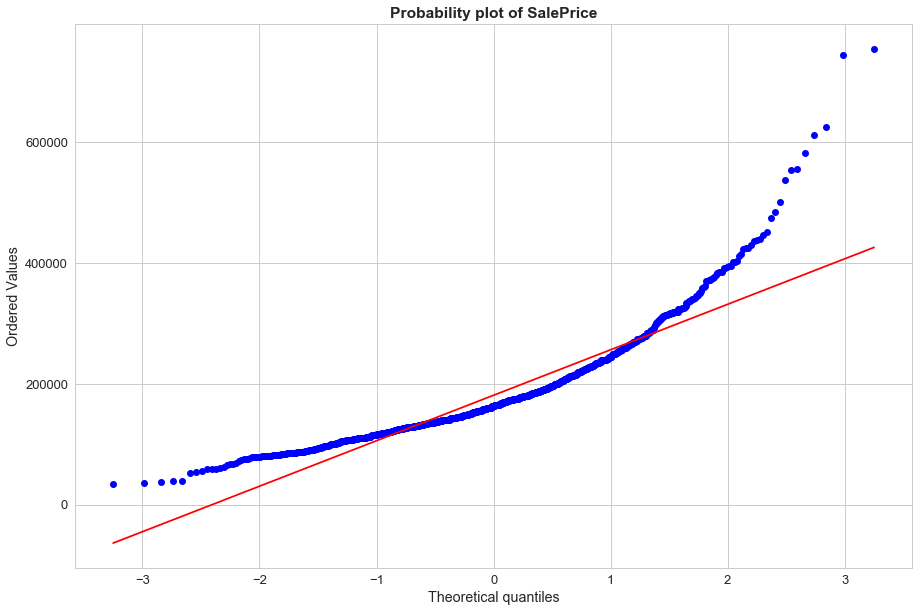

In [7]:
# PROBABILITY PLOT (SKEWNESS)
plt.figure(figsize=(15,10))
stats.probplot(train['SalePrice'], plot=plt)
plt.title("Probability plot of SalePrice", weight="semibold")
plt.show()

<div class='alert alert-success'>
Also with this plot, we can appreciate the skewness of the data. We'll deal with this aspect in the data pre-processing section.<br>
We could have analyzed the skewness of all other attributes, but we're going to stop here at the moment. Indeed, the concept (and the utility) of skewness makes sense only for numerical attributes (especially "Ratio" type, in the Stevens scale). At the moment (being only in a data exploration phase) we didn't analyzed and perfectly separed the numerical attributes from the categorical ones! We're going to do a deeper analysis in the data pre-processing phase.<br>
<br>
Now let's build the correlation matrix (of course on the numerical attributes) and check which attributes have the strongest correlation between them:
</div>

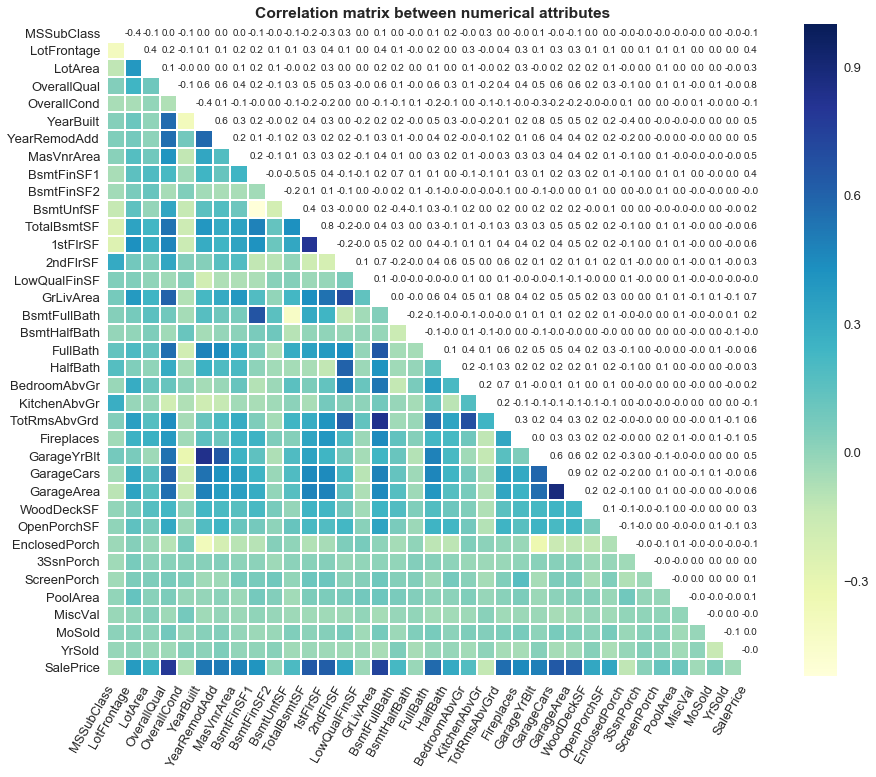

In [8]:
# BUILD THE CORRELATION MATRIX BETWEEN NUMERIC (int64 and float64) ATTRIBUTES
correlationMatrix = train[numericalAttributes].corr()

# PLOT THE CORRELATION MATRIX
plt.figure(figsize=(16,12))
plt.title("Correlation matrix between numerical attributes", weight="semibold");

# Build the Color Correlation Matrix
mask = np.zeros_like(correlationMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", fmt = '.1f', square = True, mask=mask, linewidths=1.0);

# Build the Values Correlation Matrix
mask[np.triu_indices_from(mask)] = False
mask[np.tril_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap=ListedColormap(['white']), square = True, fmt = '.1f', linewidths=1.0, mask=mask, annot=True, annot_kws={"size":10}, cbar=False);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");

<div class='alert alert-success'>
We can see that there are some values which are highly correlated. For example, <i>'GrLivArea' (Ground living area in square feet)</i> and <i>'TotRmsAbvGrd' (Total rooms above ground)</i>: this is clearly normal, because is highly probable that an house with a bigger ground living area has more rooms!<br>
There are also some negatively correlated attributes, like <i>'BsmtFullbath' (Full bathrooms in the basement)</i> and <i>'BsmtUnfSF' (Unfinished area in the basement)</i>, and this can be normal too: if there are a lot of bathrooms is highly unprobable that there is a big unfinished area in the same place.<br>
<br>
Of course these are just examples, what we can begin to care about are the attributes which are highly correlated with our target attribute: <i>'SalePrice'</i>. Let's check the correlation between the **8 most correlated** attributes (the ones with correlation value >= 0.6):
</div>

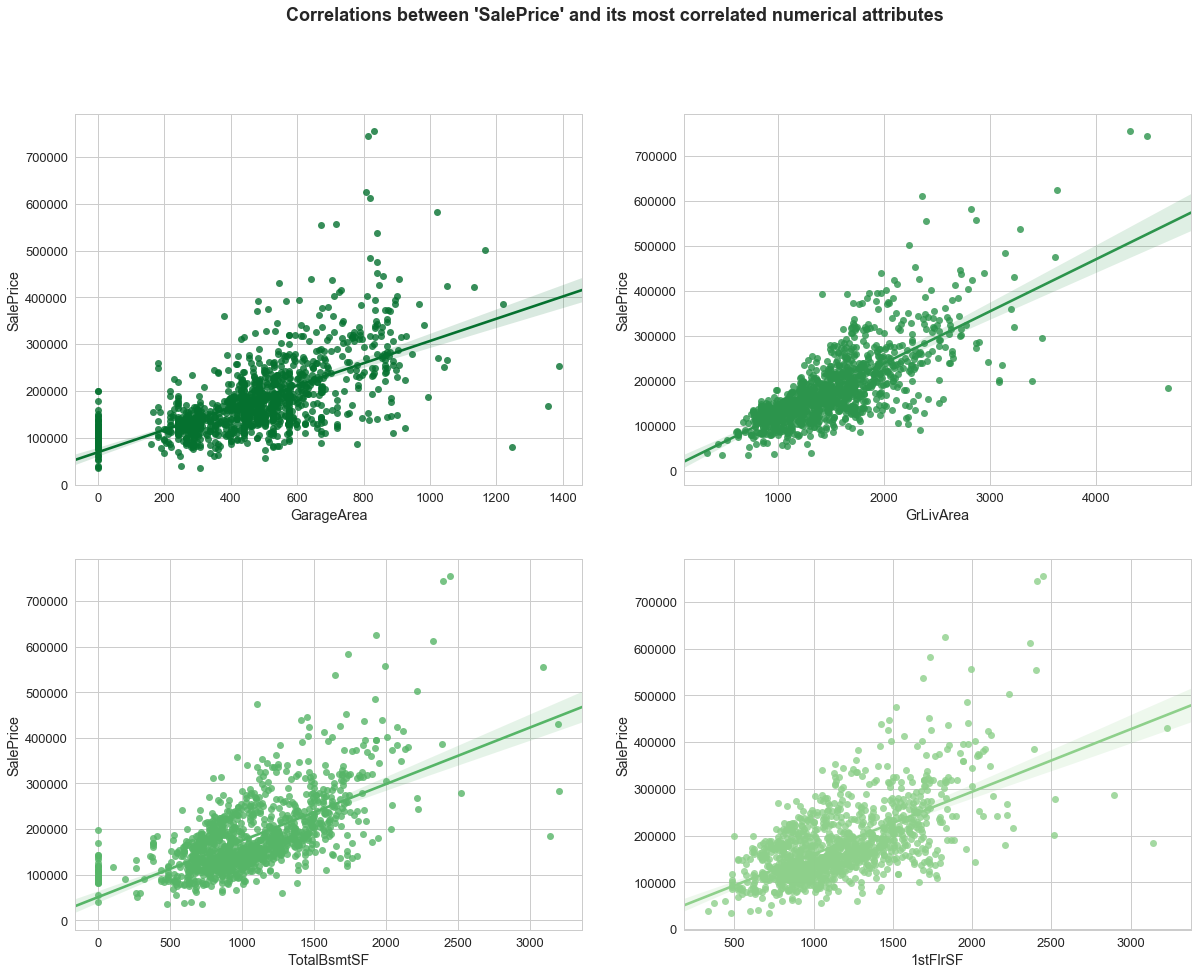

In [9]:
# PLOT THE CORRELATIONS BETWEEN 'SalePrice' AND ITS MOST CORRELATED ATTRIBUTES
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.regplot(x="GarageArea", y="SalePrice", data=train, ax=ax1);
sns.regplot(x="GrLivArea", y="SalePrice", data=train, ax=ax2);
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train, ax=ax3);
sns.regplot(x="1stFlrSF", y="SalePrice", data=train, ax=ax4);
plt.suptitle("Correlations between 'SalePrice' and its most correlated numerical attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
The attributes are of course correlated: we find that the garage area, the ground living area, the basement area and the 1st floor area are 4 of the most important attributes to decide the Sale Price of an house. What leads to some difficulties for the work of the linear regression are <b>outliers</b>: we're going to deal with them in the data pre-processing phase later.<br>
<br>
The other two highly correlated attributes are numerical outside, but "categorical" inside: indeed, we found out that they were just ordinal attributes encoded with numeric values (for example a scale from 0 to 10). For this reason, we're going to plot a boxplot instead of the regression plot. In the data pre-processing phase, we're going to transform all the attributes in numerical values, and we'll recompute the correlation matrix.<br>
<br>
At the moment, let's draw the boxplots:
</div>

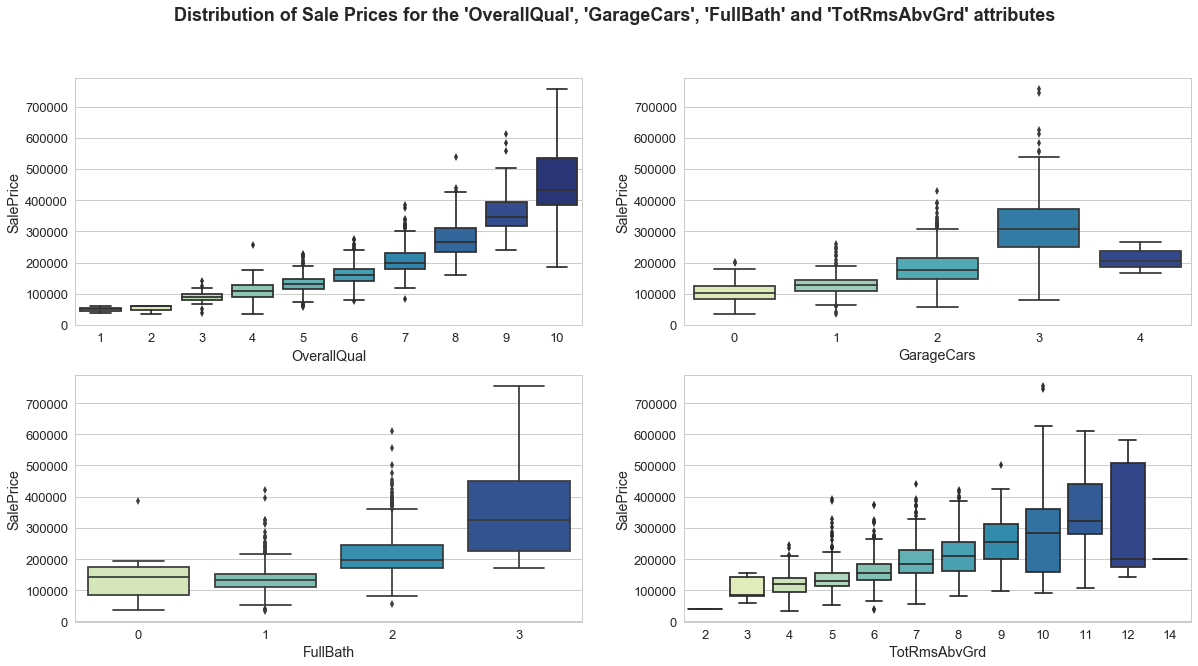

In [10]:
# PLOT THE BOXPLOTS FOR 'OverallQual','GarageCars', 'FullBath' AND 'TotRmsAbvGrd' ATTRIBUTES
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.boxplot(x="OverallQual", y="SalePrice", data=train, ax=ax1, palette="YlGnBu");
sns.boxplot(x="GarageCars", y="SalePrice", data=train, ax=ax2, palette="YlGnBu");
sns.boxplot(x="FullBath", y="SalePrice", data=train, ax=ax3, palette="YlGnBu");
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=train, ax=ax4, palette="YlGnBu");
plt.suptitle("Distribution of Sale Prices for the 'OverallQual', 'GarageCars', 'FullBath' and 'TotRmsAbvGrd' attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
Also in this case, we find outliers, especially in the plot referred to the 'TotRmsAbvGrd' attribute. We can notice that just one house has 2 rooms, and just one house has 14 rooms. However, we considered an outlier only the house with 14 rooms: the one with 2 rooms, seems in line with an hypotetical regression line passing through our data! We're going to delete the outlier house in the data pre-processing phase.
</div>

## <span style='color:#333333'>1.2 Missing values</span>

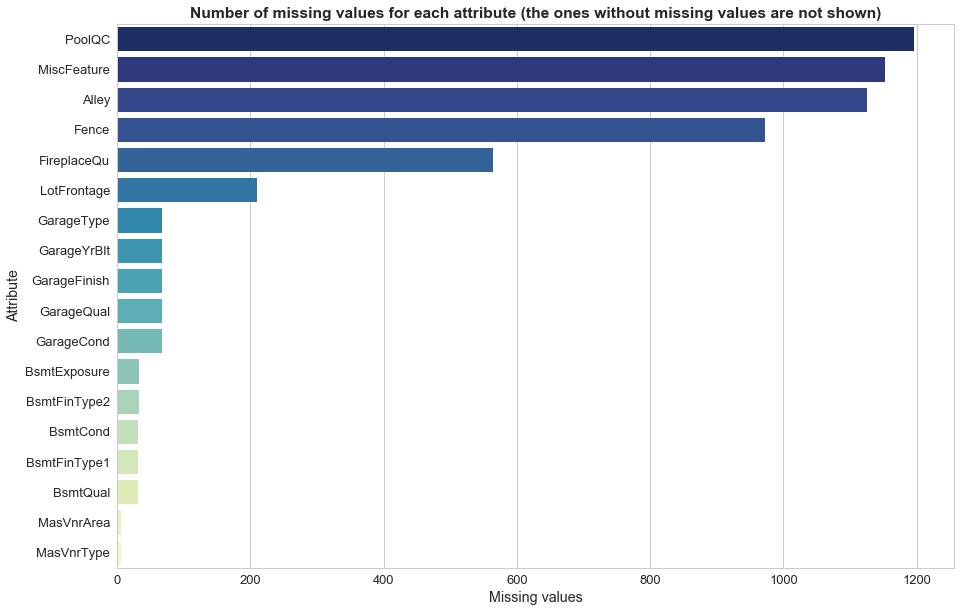

In [11]:
# EXPLORATIVE ANALYSIS ON MISSING VALUES
trainMissing = train.isnull().sum()
trainMissing = trainMissing[trainMissing != 0]
trainMissing = pd.DataFrame({"attribute":trainMissing.index, "count":trainMissing.values}).sort_values(by="count", ascending=False)

# PLOT THE BARPLOT
plt.figure(figsize=(15,10))
g = sns.barplot(y="attribute", x="count", data=trainMissing, palette="YlGnBu_r");
plt.ylabel("Attribute");
plt.xlabel("Missing values");
plt.title("Number of missing values for each attribute (the ones without missing values are not shown)", weight="semibold");

<div class='alert alert-success'>
We have a lot of missing (NaN) values! As we'll explain after, for each column a missing value can mean different things. We're going to deal with them, correcting the lack of information, in the next macro-section.
</div>

## 1.3 Skewness

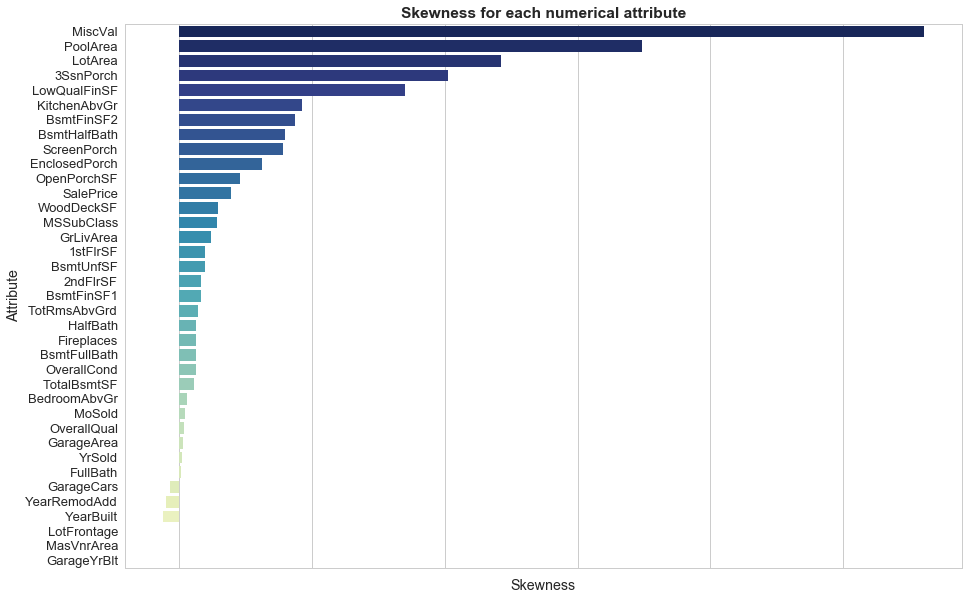

In [12]:
# COMPUTE SKEW FOR EACH OF THE NUMERICAL ATTRIBUTES
trainSkews = train[numericalAttributes].apply(lambda x: skew(x)).sort_values(ascending=False)
trainSkews = pd.DataFrame({'Attribute': trainSkews.index, 'Skew': trainSkews.values})

# PLOT THE BARPLOT
plt.figure(figsize=(15,10))
g = sns.barplot(y="Attribute", x="Skew", data=trainSkews, palette="YlGnBu_r");
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right");
plt.ylabel("Attribute");
plt.xlabel("Skewness");
plt.title("Skewness for each numerical attribute", weight="semibold");

# 2. Data cleaning and pre-processing

<div class='alert alert-success'>
Now we're going to face the data pre-processing phase. First of all, we need to do our operations in both training and test set, in order to make the modifications and the normalization we're going to do in **both** the training and test! Let's do it:
</div>

In [13]:
# CREATE THE 'allData' DATAFRAME (TRAIN + TEST)
allData = pd.concat((train, test)).reset_index(drop=True)

## <span style='color:#333333'>2.1 Dealing with missing values</span>

<div class='alert alert-success'>
The entire dataset contains, as often happens, a lot of missing values. It's important to notice that in each case, a missing value can have a <b>different meaning</b>: for example, can represent an unknown information, or can represent the lack of the property referred to that attribute! So, it's fundamental to look at the dataset description to check which is the exact meaning of the <i>NaN</i> value on a given column.<br>
<br>
We can start from categorical attributes. For them, every <i>NaN</i> represents just the lack of that given attribute (for example no pool, no basement): it's enough to fill all the missing values with the <i>"None"</i> value. Let's do that:
</div>

In [14]:
# FILLING FOR "object" ATTRIBUTES
categoricalAttributes = allData.select_dtypes(include = "object").columns.values

# FILL THEM WITH THE None VALUE
for attribute in categoricalAttributes:
    allData[attribute] = allData[attribute].fillna("None")

<div class='alert alert-success'>
For numerical attributes the situations is a bit more complex. <br>
<br>
We can start from categorical attributes. For them, every <i>NaN</i> represent just the lack of that given attribute (for example no pool, no basement): it's enough to fill all the missing values with the <i>"None"</i> value. Let's do that:
</div>

In [15]:
# VALUES FOR WHICH NaN MEANS "NOT PRESENT"
zeroList = ["GarageYrBlt", "MasVnrArea"]

# FILL
for attribute in zeroList:
    allData[attribute] = allData[attribute].fillna(0)

<div class='alert alert-success'>
<b>The lot frontage issue</b><br>
<br>
We can solve median...
But...
so...<br>
Indeed correlated to LotArea... so makes sense...
</div>

In [16]:
# FACE UP THE LOT FRONTAGE ISSUE

# Create two copies: a read one and a write one
allDataOnlyRead = deepcopy(allData)

# For each row...
for index, row in allData.iterrows():
    
    # ...if the 'LotFrontage' is NaN
    if np.isnan(row["LotFrontage"]):
        
        # Compute the neighborhood
        neighborhood = allDataOnlyRead[allDataOnlyRead["Neighborhood"] == row["Neighborhood"]]\
            [["LotFrontage", "LotArea"]].dropna().reset_index()
        
        # Take the index of the most similar street (in the neighborhood)
        closerIndex = (neighborhood["LotArea"] - row["LotArea"]).abs().argsort()[:1]
        
        # Assign the value to the original trainset
        allData.at[index, "LotFrontage"] = neighborhood.loc[closerIndex]["LotFrontage"]

In [17]:
# BUILD A SAMPLE TO SHOW SOME NaNs
sampleWithNaN = allDataOnlyRead[allDataOnlyRead["Neighborhood"] == 'Mitchel'][["LotFrontage","LotArea"]].sort_values(by="LotArea", ascending=False).head(15)

# BUILD A SAMPLE WITH REMOVED NaNs
sampleWithoutNaN = allData[allData["Neighborhood"] == 'Mitchel'][["LotFrontage","LotArea"]].sort_values(by="LotArea", ascending=False).head(15)

# COMPARE
compareSideBySide(sampleWithNaN.as_matrix(),
                  sampleWithoutNaN.as_matrix(),
                  index=sampleWithNaN.index,
                  header=["LotFrontage","LotArea"],
                  title="<i>'LotFrontage'</i>: before and after the NaN removal")

,LotFrontage,LotArea
1190,NaN,32463.0
1446,NaN,26142.0
876,94.0,25286.0
943,100.0,25000.0
422,100.0,21750.0
1048,100.0,21750.0
1434,80.0,17400.0
1453,90.0,17217.0
5,85.0,14115.0
817,NaN,13265.0


## <span style='color:#333333'>2.2 Removing outliers</span>

<div class='alert alert-success'>
We're now going to remove some outliers. We won't do an aggressive outlier removal: we'll remove the points which area clearly outside and very far from the ideal regression for the "Attribute/SalePrice" data.<br>
We'll do that also for a restricted set of attributes, just the ones which are higly correlated to our SalePrice target. Of course we're going to "touch" only the trainset.
</div>

In [18]:
# REMOVING OUTLIERS FOR HIGHLY CORRELATED ATTRIBUTES
# (ONLY FOR TRAIN-SET!)

# TEMPORARY SPLIT
train = allData[:1200]
test = allData[1200:]

# OUTLIER REMOVAL

#train = train.drop(train.index[[520, 362, 1179, 419, 169, 1038, 304, 1173, 89, 574, 1, 11, 144, 285, 350, 799]])


# SalePrice
train = train.drop(train[train['SalePrice'] > 440000].index)
# OpenPorchSF
#train = train.drop(train[(train['OpenPorchSF'] > 20) & (train['SalePrice'] < 45000)].index)
# GarageCars
train = train.drop(train[(train['GarageCars'] == 2) & (train['SalePrice'] > 305000)].index) # 18 / 1180
# OverallQual
train = train.drop(train[(train['OverallQual'] == 8) & (train['SalePrice'] > 410000)].index) # 0 / 1575

# RE-JOIN
allData = pd.concat((train, test)).reset_index(drop=True)


print("Now the number of rows (which was " + str(allDataOnlyRead.shape[0]) + ") is now " + str(allData.shape[0]))

Now the number of rows (which was 1460) is now 1424


<div class='alert alert-success'>
Now we're going to re-plot the distributions of our 8 most "SalePrice-correlated" attributes and see if they improved our regressions.
</div>

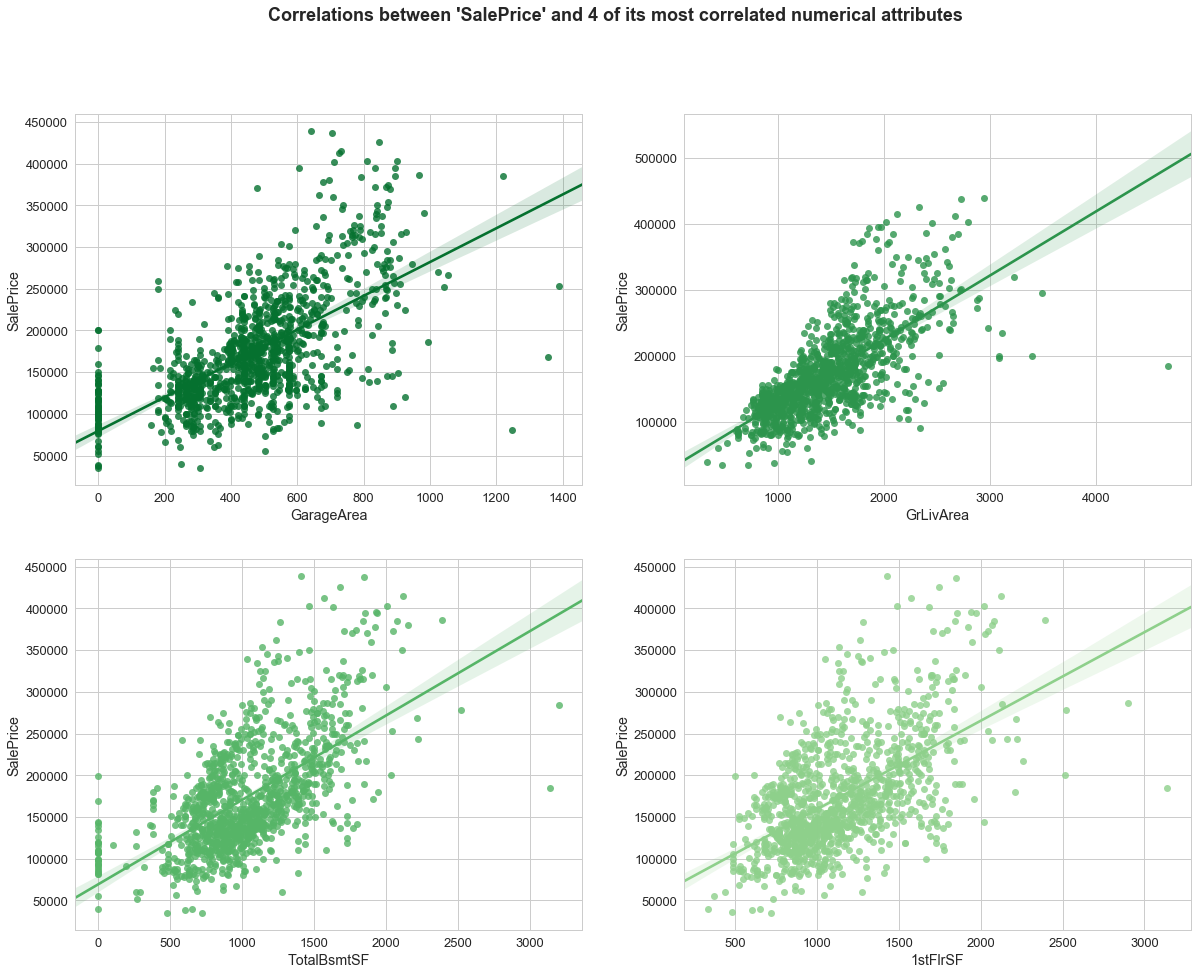

In [19]:
# RE-PLOT THE CORRELATIONS BETWEEN 'SalePrice' AND ITS MOST CORRELATED NUMERICAL ATTRIBUTES
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.regplot(x="GarageArea", y="SalePrice", data=allData, ax=ax1);
sns.regplot(x="GrLivArea", y="SalePrice", data=allData, ax=ax2);
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=allData, ax=ax3);
sns.regplot(x="1stFlrSF", y="SalePrice", data=allData, ax=ax4);
plt.suptitle("Correlations between 'SalePrice' and 4 of its most correlated numerical attributes", weight="semibold", fontsize=18);

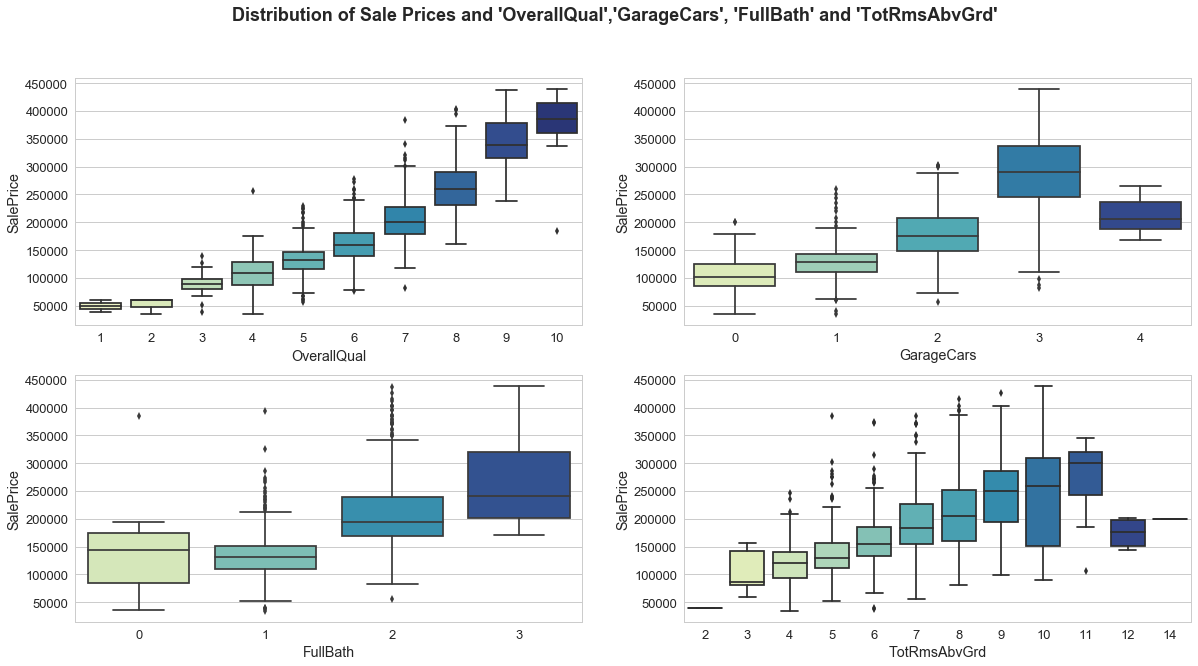

In [20]:
# RE-PLOT THE BOXPLOTS FOR 'OverallQual','GarageCars', 'FullBath' AND 'TotRmsAbvGrd' ATTRIBUTES
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.boxplot(x="OverallQual", y="SalePrice", data=allData, ax=ax1, palette="YlGnBu");
sns.boxplot(x="GarageCars", y="SalePrice", data=allData, ax=ax2, palette="YlGnBu");
sns.boxplot(x="FullBath", y="SalePrice", data=allData, ax=ax3, palette="YlGnBu");
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=allData, ax=ax4, palette="YlGnBu");
plt.suptitle("Distribution of Sale Prices and 'OverallQual','GarageCars', 'FullBath' and 'TotRmsAbvGrd'", weight="semibold", fontsize=18);

<div class='alert alert-success'>
As we can clearly see, the situation is now clearly better. The outliers (or in better words, the data points we considered to be outliers) have been removed. We can go ahead.
</div>

## <span style='color:#333333'>2.3 Label Encoding and DataType Correction</span>

<div class='alert alert-success'>
Some categorical attributes are originally "objects" in our dataset. In order to make the model work, we have to transform them into numerical (ordinal) attributes, like the 'OverallQual' and 'OverallCond' originally are (scale from 1 to 10).<br>
<br>
We're going to use <b>Label Encoding</b> and the <b>One Hot Encoding</b>, and we explain why:<br>
<br>
<list>
    <li>the Label Encoding is useful when we want to transform the categorical attribute in a numeric one, <b>keeping the ordinality information</b>. This means that if an attribute range is ["none", "bad", "average", "good", "excellent"], makes sense to transform it into [0, 1, 2, 3, 4].</li>
    <li>the One Hot Encoding is useful when we want to transform categorical attributes into numerical ones, but <b>without</b> letting the numerical value to be ordinal. This means that if an attribute has a domain range like ["red", "green", "blue"] can be a problem to transform it into a [0, 1, 2] range, because the model will learn an ordinality which is not present in reality! In these cases we use a One Hot Encoding, that duplicates the columns for a given attribute, and gives the value 0 or 1.</li> 
</list><br>
In our case, analyzing all the attributes in the data description, we noticed that for some attributes was more appropriate to use the LabelEncoder, for others the OneHotEncoder.<br> There are some exceptions: some attributes with cardinality 2; in that case, even if we don't want an "ordinality" information, using a OneHotEncoder is totally useless because the value can be just one thing or another (0 or 1 in a numerical fashion). This attributes are "CentralAir" and "Street".<br>
<br>
Instead of the scikit-learn <i>OneHotEncoder</i> function, we used the Pandas <i>get_dummies</i>: it can be done on the entire dataframe (of course only in the attributes we want to apply it) with a single call, without looping through the columns. It has a useful features (<i>drop_first</i>) that helps to avoid the "dummy variable trap" (<a href="http://www.algosome.com/articles/dummy-variable-trap-regression.html">source</a>):<br>
in simple words, is always useful to drop the first variable during a categorical variables encoding in a one-hot fashion, to avoid a non-desired collinearity.
</div>

In [21]:
# COLLECT IN A LIST THE CATEGORICAL ATTRIBUTES WITHOUT THE "ORDINAL" SCALE
notOrderedColumns = ['MSZoning', 'Alley', 'LandContour', 'LotConfig','Neighborhood', 'Condition1', 'Condition2','BldgType',
                     'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation',
                     'Heating', 'Electrical', 'GarageType','MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']

# USE THE ONE-HOT ENCODER FOR THESE ATTRIBUTES
allData = pd.get_dummies(allData, columns=notOrderedColumns, drop_first=True)

<div class='alert alert-success'>
Now we're going to encode the categorical attributes that have an "ordinality" information inside. Some of them were just of "object" type, but others were not! They were just "categorical" (ordinal) attributes encoded as int64. In the encode function we take care of this.
</div>

In [22]:
# ENCODING FUNCTION
def encode(col):
    if col.dtype == np.object:
        return LabelEncoder().fit_transform(col).astype(np.uint32)
    elif (col.name == 'OverallQual' or col.name == 'MSSubClass' or col.name == 'OverallCond' or col.name == 'Id' or \
         col.name == 'MoSold' or col.name == 'YrSold' or col.name == 'YearRemodAdd' or col.name == 'YearBuilt' or \
         col.name == 'GarageYrBlt'):
        return col.astype(np.uint32)
    else:
        return col
    
# ENCODE THE CATEGORICAL VALUES IN NUMERICAL VALUES
allData = allData.apply(encode, axis=0, reduce=False)

# SHOW
display(allData.head(10))

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,856,854,0,3,4,3,706,0,2,6,...,1,0,0,0,0,0,0,0,0,0
1,1262,0,0,3,4,1,978,0,0,6,...,0,0,0,0,0,0,0,0,0,0
2,920,866,0,3,4,2,486,0,2,6,...,1,0,0,0,0,0,0,0,0,0
3,961,756,0,3,1,3,216,0,0,6,...,0,1,0,0,0,0,0,0,0,0
4,1145,1053,0,4,4,0,655,0,2,6,...,1,0,0,0,0,0,0,0,0,0
5,796,566,320,1,4,3,732,0,2,6,...,0,0,0,0,0,0,0,0,0,0
6,1107,983,0,3,4,2,859,32,0,1,...,1,0,0,0,0,0,0,0,0,0
7,1022,752,0,2,4,3,0,0,6,6,...,0,0,0,0,0,0,0,0,0,0
8,1077,0,0,2,4,3,851,0,2,6,...,0,0,0,0,0,0,0,0,0,1
9,1040,0,0,3,4,3,906,0,5,6,...,0,0,0,0,0,0,0,0,0,0


<div class='alert alert-success'>
As we saw in the previous parts of the notebook, we're dealing about numerical and categorical attributes. However, as previously said, some categorical attributes are already encoded as numerical values, other are just 'objects'. With our encoding, we transformed all the 'objects' to <i>'np.uint8'</i> values (which is also the format in which the 'get_dummies' function encodes the columns) to distinguish them from the numerical ones (<i>'int64'</i> or <i>'float64'</i>).<br>
<br>
Our assumptions have been done also recalling the Stevens Scale Levels:
<img src='http://my.ilstu.edu/~wjschne/138/Stevens.png' height="600" width="600">
<br>
We brought a coherent structure to our dataset. Now we can update our variables:
</div>

In [23]:
# UPDATE THE NUMERICAL AND CATEGORICAL TRAINSET

# NUMERICAL: exclude uint8 and uint32 (include int64 and float64)
numericalAttributes = allData.select_dtypes(exclude=["uint8", "uint32"]).drop(columns=["SalePrice"]).columns.values

# NOMINAL CATEGORICAL: include uint8
nominalCategoricalAttributes = allData.select_dtypes(include="uint8").columns.values

# ORDINAL CATEGORICAL: include uint32
ordinalCategoricalAttributes = allData.select_dtypes(include="uint32").columns.values

<div class='alert alert-success'>
Now we can print the correlation matrix for the categorical attributes! Before, indeed, was impossible because they were strings and not numerical values.
</div>

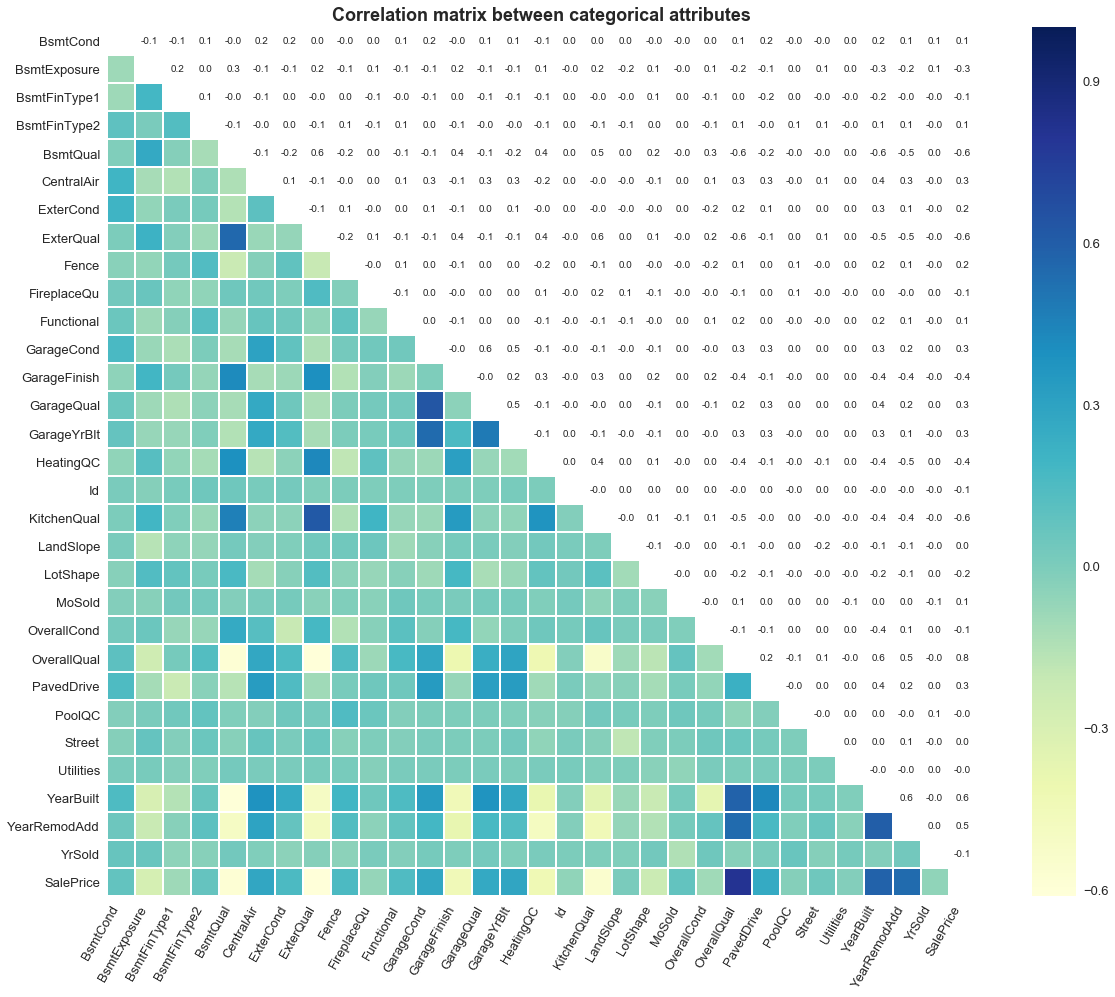

In [24]:
# PRINT AGAIN THE CORRELATION MATRIX (NOW THAT CATEGORICAL ATTRIBUTES HAVE BECOME NUMERICAL)

# APPEND THE 'SalePrice' LABEL TO THE CATEGORICAL DATASET
allDataCategoricalWithSalePrice = allData[np.append(ordinalCategoricalAttributes, "SalePrice")]

# BUILD THE CORRELATION MATRIX BETWEEN CATEGORICAL ATTRIBUTES AND 'SalePrice'
correlationMatrix = allDataCategoricalWithSalePrice.corr()

# PLOT THE CORRELATION MATRIX
plt.figure(figsize=(20,16))
mask = np.zeros_like(correlationMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", square = True, fmt = '.1f', mask=mask, linewidths=1.0);
mask[np.triu_indices_from(mask)] = False
mask[np.tril_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap=ListedColormap(['white']), square = True, fmt = '.1f', linewidths=1.0, mask=mask, annot=True, annot_kws={"size":10}, cbar=False);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");
plt.title("Correlation matrix between categorical attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
The correlation matrix highlights some high correlations between "Exterior1st" and "Exterior2nd" (the materials used to cover the house), or between the kitchen quality and the exterior quality. However, what do we care most is the last row: none of the attributes has a peak of correlation with our 'SalePrice' label. The numerical attributes had a bigger impact on our 'SalePrice' label.<br>
<br>
It's crucial to notice that for a lot of attributes, the sign of the correlation matrix is the opposite of what we expect: **this is normal** for our Label Encoding construction. The attributes in the lower steps get an high numerical value, the attributes in higher steps receive a low numerical value (e.g. No pool: 3, Bad pool: 2, etc.). We tried to change this behaviour but we didn't succedeed using only the methods provided by the scikit-learn library; we could have done an own algorithm, but it would have been uselessly time-spending and maybe not as efficient as the one in the library. It's just convention therefore we decided to leave things in this state.
</div>

## <span style='color:#333333'>2.4 Feature engineering</span>

<div class='alert alert-success'>
...
</div>

## <span style='color:#333333'>2.5 PCA - Detecting outliers from an helicopter view</span>

<div class='alert alert-success'>
As we've seen in the Exploration phase, our label was left-skewed. In this section we're going to deal with this issue, and we're also going to analyze and correct the skewness of the numerical attributes, now that we own a correct division between the categorical and numerical ones.
</div>

In [25]:
# TEMPORARY SPLIT
trainPCA = allData[np.isnan(allData["SalePrice"]) == False]
#test = allData[np.isnan(allData["SalePrice"]) != False].drop(columns=['SalePrice'])

### <span style='color:#606060'>2.5.1 Target variable</span>

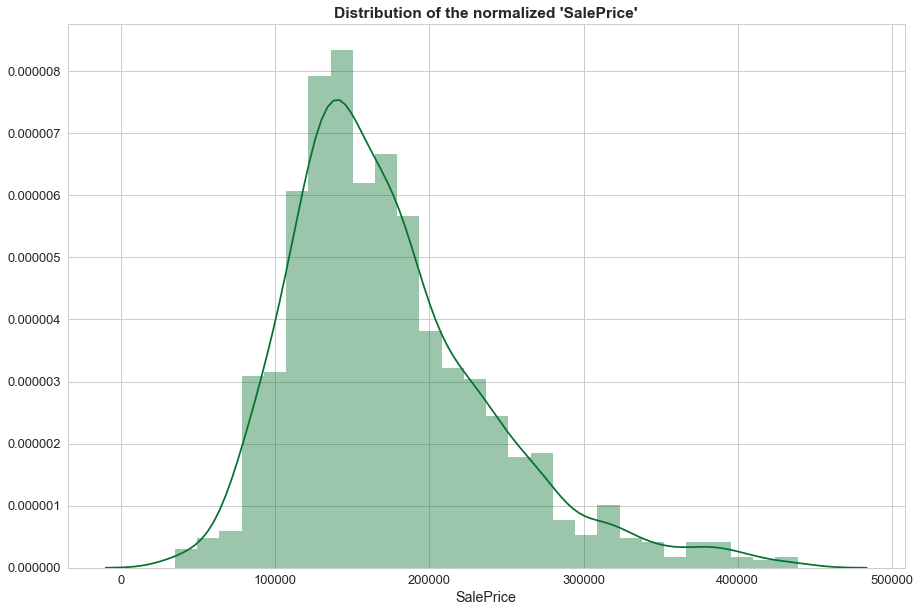

In [26]:
# NORMALIZE THE TARGET VARIABLE TO SIMPLIFY THE MODEL's WORK
#trainPCA["SalePrice"] = np.log1p(trainPCA["SalePrice"])

# PLOT AGAIN THE VALUES DISTRIBUTION
plt.figure(figsize=(15,10))
sns.distplot(trainPCA["SalePrice"]);
plt.title("Distribution of the normalized 'SalePrice'", weight="semibold");

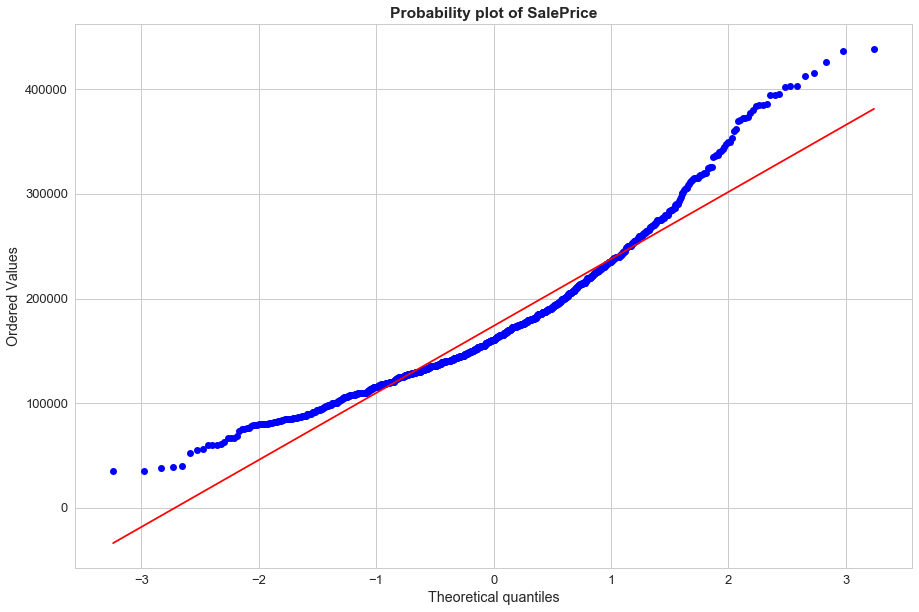

In [27]:
# PROBABILITY PLOT (SKEWNESS)
plt.figure(figsize=(15,10))
stats.probplot(trainPCA['SalePrice'], plot=plt)
plt.title("Probability plot of SalePrice", weight="semibold")
plt.show()

### <span style='color:#606060'>2.5.2 Numerical attributes</span>

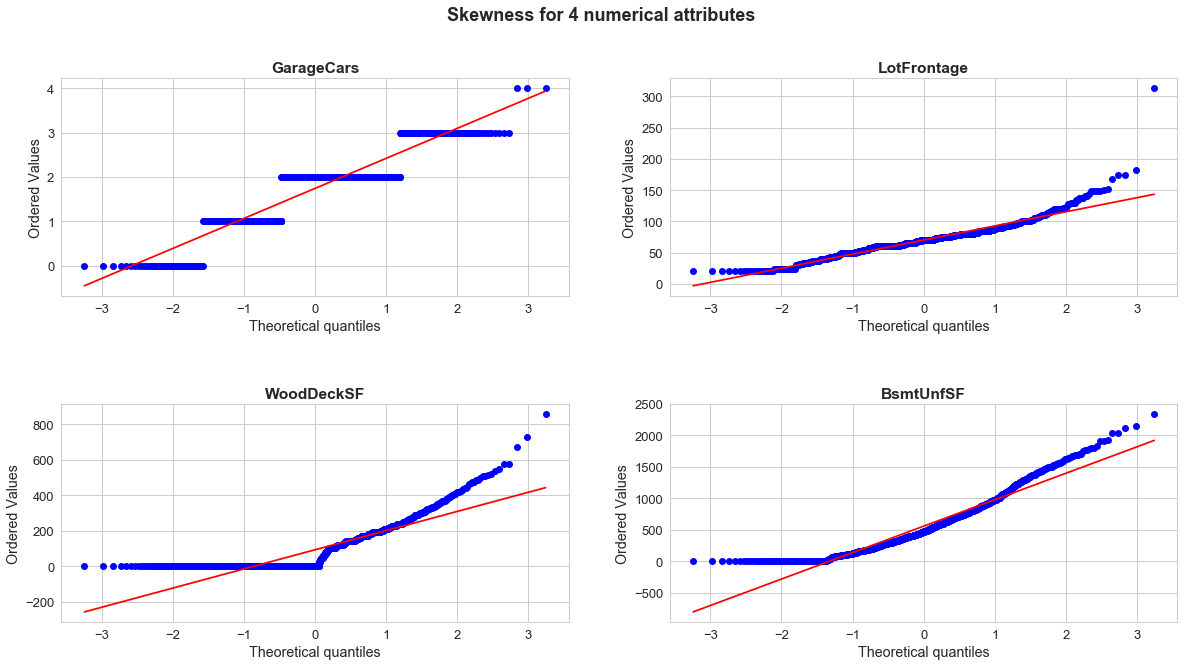

In [28]:
# PLOT THE ATTRIBUTES SKEWNESSES
plt.figure(figsize=(20,10))
for (i, attribute) in enumerate(['GarageCars', 'LotFrontage', 'WoodDeckSF', 'BsmtUnfSF']):
    
    # PROBABILITY PLOT (SKEWNESS)
    plt.subplot(2, 2, i+1)
    stats.probplot(trainPCA[attribute], plot=plt)
    plt.title(attribute, weight="semibold")

plt.suptitle("Skewness for 4 numerical attributes", weight="semibold", fontsize=18)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [29]:
trainPCA = np.log1p(trainPCA)

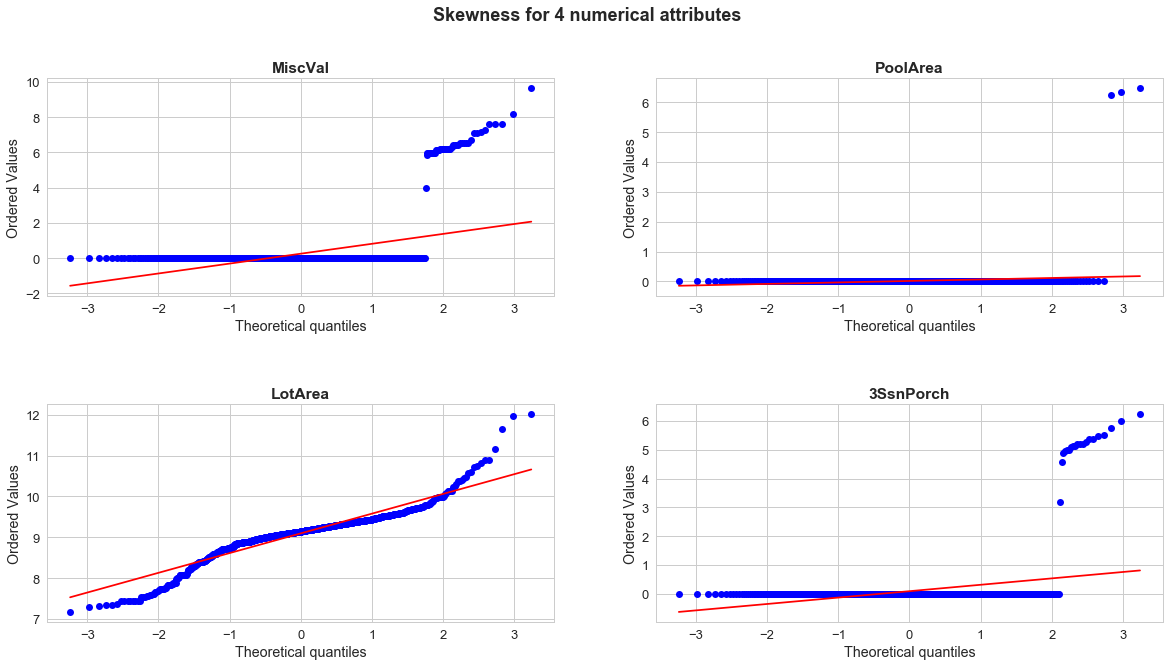

In [30]:
# PLOT THE ATTRIBUTES SKEWNESSES
plt.figure(figsize=(20,10))
for (i, attribute) in enumerate(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch']):
    
    # PROBABILITY PLOT (SKEWNESS)
    plt.subplot(2, 2, i+1)
    stats.probplot(trainPCA[attribute], plot=plt)
    plt.title(attribute, weight="semibold")

plt.suptitle("Skewness for 4 numerical attributes", weight="semibold", fontsize=18)
plt.subplots_adjust(hspace=0.5)
plt.show()

### <span style='color:#606060'>2.5.3 Principal component analysis</span>

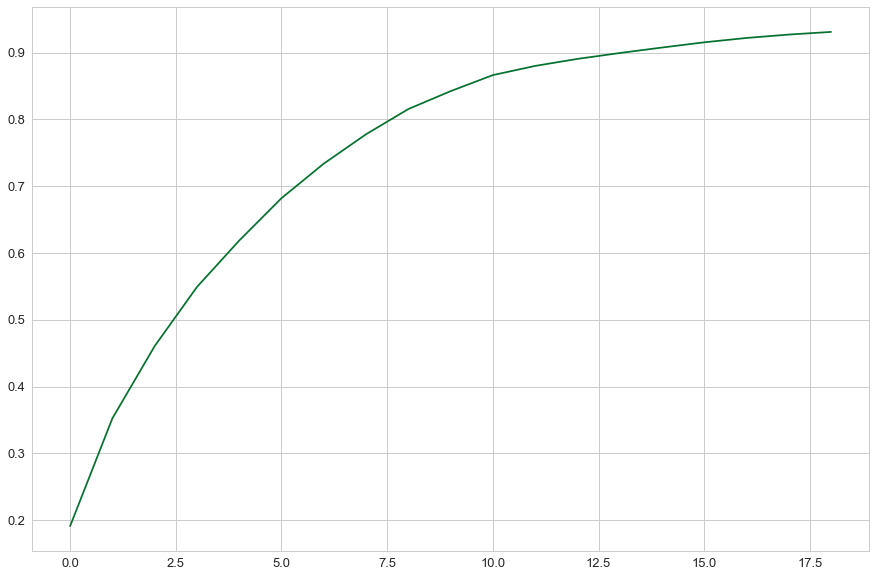

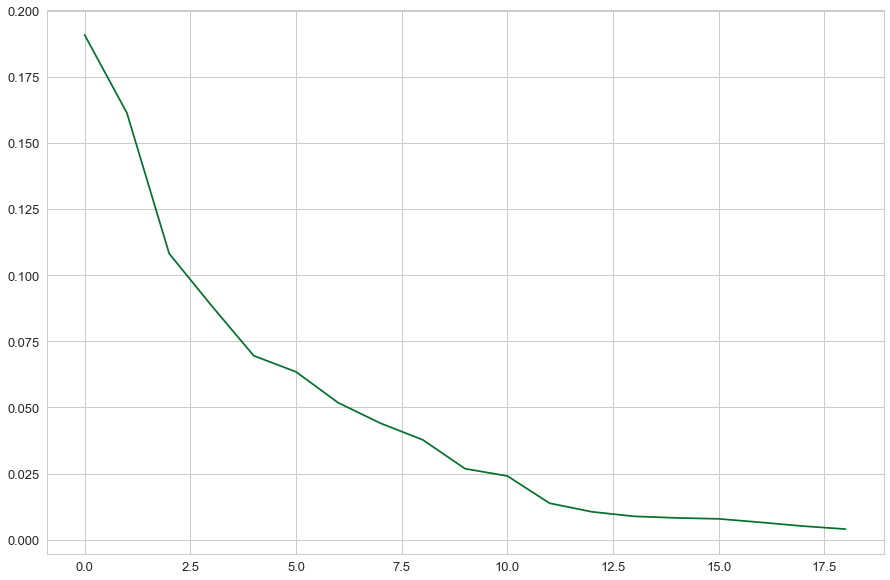

In [31]:
from sklearn.decomposition import PCA

sums = []

for i in range(1,20):
    pca = PCA(n_components=i, svd_solver='full')
    pc = pca.fit_transform(trainPCA)
    
    #display(pd.DataFrame(data=pc))
    expl = np.sum(pca.explained_variance_ratio_)
    sums.append(expl)


plt.figure(figsize=(15,10))
plt.plot([i for i in range(0, len(sums))], sums)
plt.show()

plt.figure(figsize=(15,10))
plt.plot([i for i in range(0, 19)], pca.explained_variance_ratio_)
plt.show()

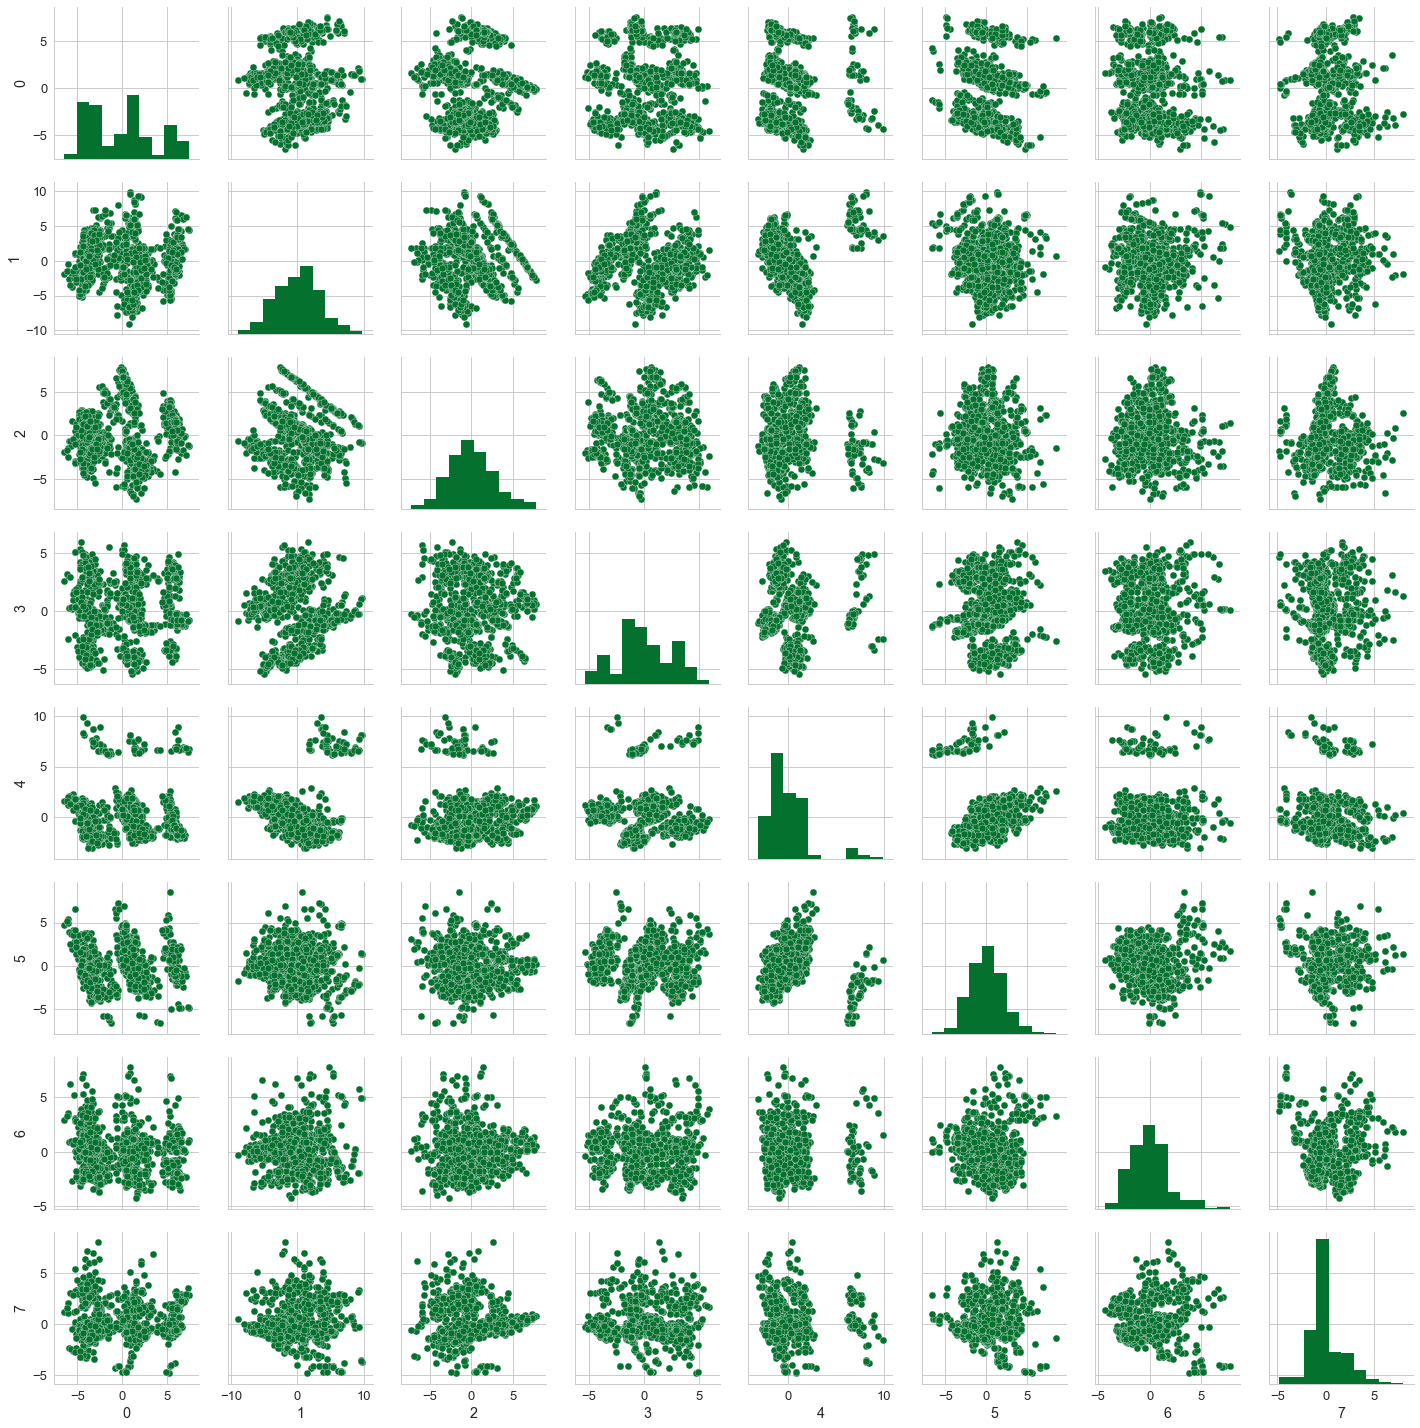

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8, svd_solver='full')
pc = pca.fit_transform(trainPCA)
pdf = pd.DataFrame(data=pc)

plt.figure(figsize=(10,10))
sns.pairplot(pdf)
plt.show()

Counter({0: 914, 1: 174, -1: 47, 2: 29})
Int64Index([  38,   46,   76,   86,   87,  106,  125,  138,  153,  160,  204,
             217,  280,  317,  334,  365,  382,  420,  482,  509,  513,  518,
             580,  594,  601,  617,  623,  629,  641,  681,  686,  738,  799,
             816,  939,  941,  947,  980,  982, 1001, 1009, 1018, 1036, 1099,
            1105, 1110, 1145],
           dtype='int64')


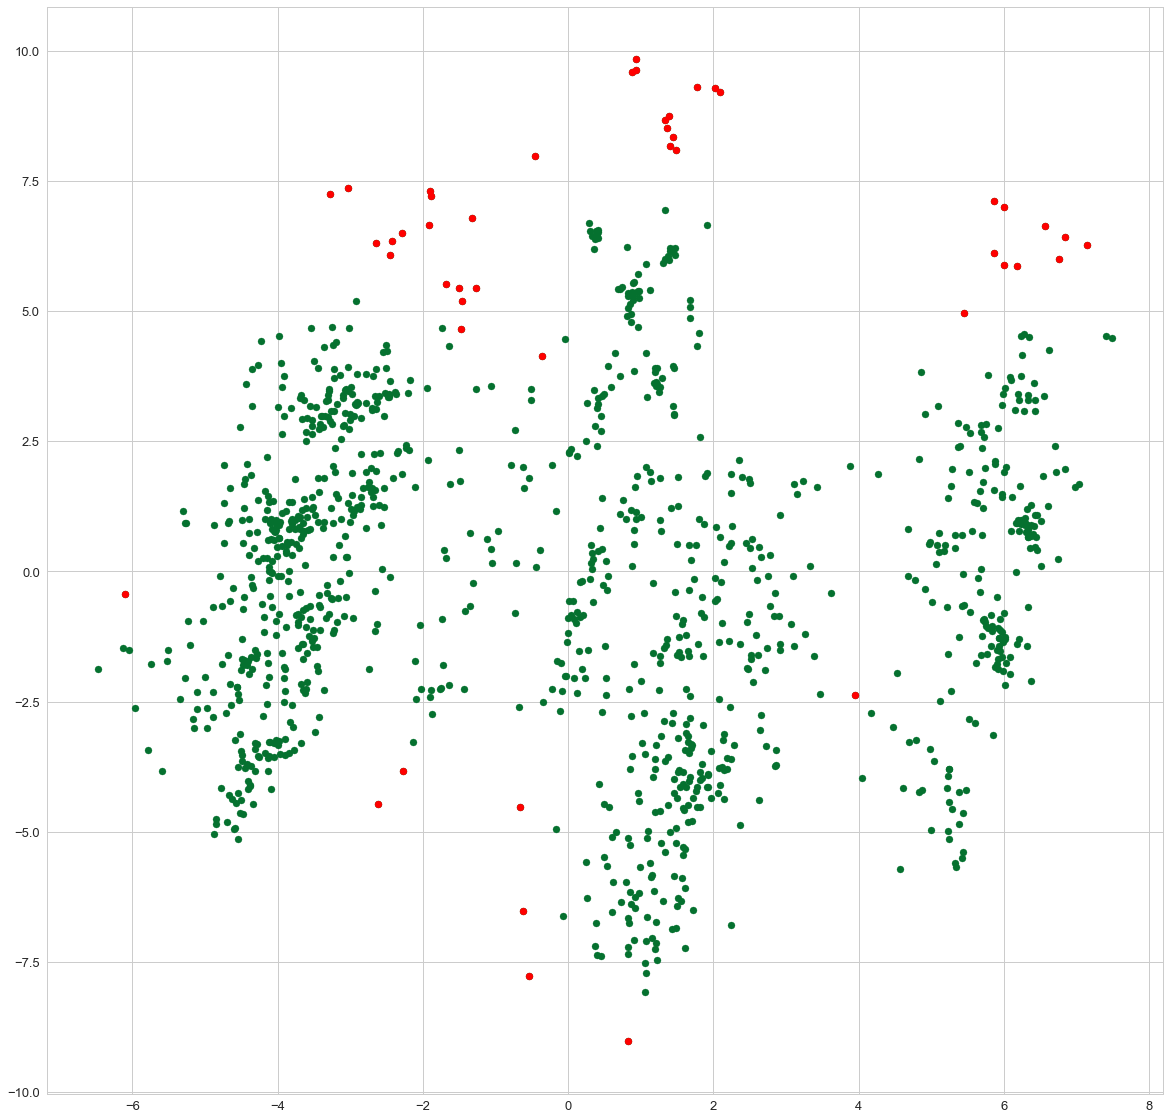

In [33]:
from sklearn.cluster import DBSCAN
from collections import Counter


pca = PCA(n_components=2, svd_solver='full')
pc = pca.fit_transform(trainPCA)
pdf = pd.DataFrame(data=pc)

model = DBSCAN(eps=0.9, min_samples=10)
outliers = model.fit(pdf)

print(Counter(outliers.labels_))

onlyOutliers = pdf[outliers.labels_ == -1]
print(onlyOutliers.index)

plt.figure(figsize=(20,20))
plt.scatter(x=pdf[0], y=pdf[1])
plt.scatter(x=onlyOutliers[0], y=onlyOutliers[1], color="r")
plt.show()


In [34]:
# REMOVING OUTLIERS FOR HIGHLY CORRELATED ATTRIBUTES
# (ONLY FOR TRAIN-SET!)

# TEMPORARY SPLIT
train = allData[np.isnan(allData["SalePrice"]) == False]
test = allData[np.isnan(allData["SalePrice"]) != False].drop(columns=['SalePrice'])

# OUTLIER REMOVAL
# train = train.drop(train.index[[352, 1145, 506, 297, 558, 1009, 1139, 87, 704, 1, 10, 773]])
# train = train.drop(train.index[[80, 217, 222, 326, 334, 464, 509, 530, 580, 601, 623, 641, 732, 994]])
# train = train.drop(train.index[[80,  205, 217, 222, 326, 334, 464, 509, 530, 580, 601, 623, 641]])
train = train.drop(train.index[[  38,   46,   76,   86,   87,  106,  125,  138,  153,  160,  204,
             217,  280,  317,  334,  365,  382,  420,  482,  509,  513,  518,
             580,  594,  601,  617,  623,  629,  641,  681,  686,  738,  799,
             816,  939,  941,  947,  980,  982, 1001, 1009, 1018, 1036, 1099,
            1105, 1110, 1145]])

# RE-JOIN
allData = pd.concat((train, test)).reset_index(drop=True)


print("Now the number of rows (which was " + str(allDataOnlyRead.shape[0]) + ") is now " + str(allData.shape[0]))

Now the number of rows (which was 1460) is now 1377


In [35]:
train["SalePrice"] = np.log1p(train["SalePrice"])

# 3. Modeling

## Neural Network

In [267]:
# Load libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Number of features
features = train.drop(columns=["Id", "SalePrice"])
target = train["SalePrice"]

print(features.shape)

# define base model
def baseline_model():
    # create model
    model = Sequential()
    
    model.add(Dense(800, input_dim=215, kernel_initializer='normal', activation="relu"))
    model.add(Dense(400, kernel_initializer='normal', activation="relu"))
    model.add(Dense(200, kernel_initializer='normal', activation="relu"))
    model.add(Dense(100, kernel_initializer='normal', activation="relu"))
    model.add(Dense(50, kernel_initializer='normal', activation="relu"))
    model.add(Dense(25, kernel_initializer='normal', activation="relu"))
    model.add(Dense(10, kernel_initializer='normal', activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# fix random seed for reproducibility
# evaluate model with standardized dataset
seed=7
np.random.seed(seed)
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=32, verbose=False)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, features, target, cv=kfold)
print("CV: %.2f RMSE" % (np.sqrt(abs(results.mean()))))

#
#
# Evaluate neural network using three-fold cross-validation
#print(np.sqrt(np.mean(cross_val_score(neural_network, features, target, cv=10))))
from sklearn.metrics import mean_squared_error


# Load test 2
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]

# Fit and predict
pipeline.fit(features, target)
#print(np.sqrt(mean_squared_error(np.log(target2), np.log(pipeline.predict(test.drop(columns=["Id"]))))))
print(np.sqrt(mean_squared_error(np.log1p(target2), pipeline.predict(test.drop(columns=["Id"])))))

/Users/luca/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(1117, 215)
CV: 0.32 RMSE
0.377151015360243


## 3.1 XGBoost with Bayesian Optimization

In [38]:
features = train.drop(columns=["Id", "SalePrice"])
target = train["SalePrice"]

In [152]:
folds = 100
RMSEbest = 10.0
ITERbest = 0

def xgbCV(max_depth, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, reg_alpha, reg_lambda, learning_rate):
    global RMSEbest
    global ITERbest

    random.seed(datetime.now())
    # Defining XGBoost parameters object
    parameters = {
              'booster' : 'gbtree',
              'max_depth' : max_depth.astype(int),
              'gamma' : gamma,
              'objective': 'reg:linear',
              'nthread' : 8,
              'silent' : True,
              'eval_metric': 'rmse',
              'subsample' : subsample,
              'colsample_bytree' : colsample_bytree,
              'min_child_weight' : min_child_weight,
              'max_delta_step' : max_delta_step.astype(int),
              'learning_rate': learning_rate,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'seed' : 7
              }
    
    # initialize cvScore before cross-validation
    cvScore = 0

    xgbCV = xgboost.cv(parameters,
                  dtrain,
                  num_boost_round = 1000,
                  nfold = folds,
                  verbose_eval = False,
                  early_stopping_rounds = 25,
                  metrics = "rmse",
                  show_stdv = True)

    cvScore = xgbCV['test-rmse-mean'].iloc[-1]
    if ( cvScore < RMSEbest ):
        RMSEbest = cvScore
        ITERbest = len(xgbCV)

    return (-1.0 * cvScore)

In [154]:
dtrain = xgboost.DMatrix(features, label = target)

bayesianOptimizerXGB = BayesianOptimization(xgbCV, {'max_depth': (2, 5),
                                     'gamma': (0.01, 0.1),
                                     'min_child_weight': (0, 5),
                                     'max_delta_step': (5, 8),
                                     'subsample': (0.3, 0.7),
                                     'colsample_bytree' :(0.1, 0.7),
                                     'reg_alpha': (0.1, 0.5),
                                     'reg_lambda': (0.1, 0.5),
                                     'learning_rate': (0.01, 0.5)
                                    })

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    bayesianOptimizerXGB.maximize(init_points=10, n_iter=25, acq="ei")

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_delta_step |   max_depth |   min_child_weight |   reg_alpha |   reg_lambda |   subsample | 
    1 | 00m55s |   -0.11191 |             0.3194 |    0.0446 |          0.3069 |           5.5397 |      2.0798 |             4.3129 |      0.4438 |       0.3626 |      0.6008 | 
    2 | 02m26s |   -0.10361 |             0.1460 |    0.0526 |          0.0369 |           5.7814 |      2.6153 |             4.0566 |      0.3008 |       0.3076 |      0.5316 | 
    3 | 02m52s |   -0.10462 |             0.2534 |    0.0857 |          0.0527 |           5.9082 |      3.3990 |             0.3101 |      0.1200 |       0.1338 |      0.4576 | 
    4 | 00m33s |   -0.11497 |             0.4792 |    0.0602 |          0.4577 |           

In [155]:
bayesianOptimizerXGB.res['max']['max_params']

{'colsample_bytree': 0.15275870262115382,
 'gamma': 0.01000000071031035,
 'learning_rate': 0.019393706480347113,
 'max_delta_step': 6.5997914827179684,
 'max_depth': 4.355636805875182,
 'min_child_weight': 0.3088656523619646,
 'reg_alpha': 0.10000000054853612,
 'reg_lambda': 0.41655156862289555,
 'subsample': 0.6649017481878564}

In [186]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.15275870262115382, gamma=0.01000000071031035, 
                             max_depth=4, learning_rate=0.019393706480347113,
                             max_delta_step=6.5997914827179684,
                             min_child_weight=0.3088656523619646, n_estimators=2000,
                             reg_alpha=0.10000000054853612, reg_lambda=0.41655156862289555,
                             subsample=0.6649017481878564, silent=1,
                             random_state = 38, nthread = -1)

In [187]:
from sklearn.metrics import mean_squared_error

xgb.fit(features, target)

# open train2 and get 1201 -> 1460
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]
# drop id and saleprice
# call test2

xgbPred = xgb.predict(test.drop(columns=["Id"]))
xgbErr = np.sqrt(mean_squared_error(np.log1p(target2), xgbPred))

print("XGBoost prediction:", xgbErr)

XGBoost prediction: 0.12489504579945267


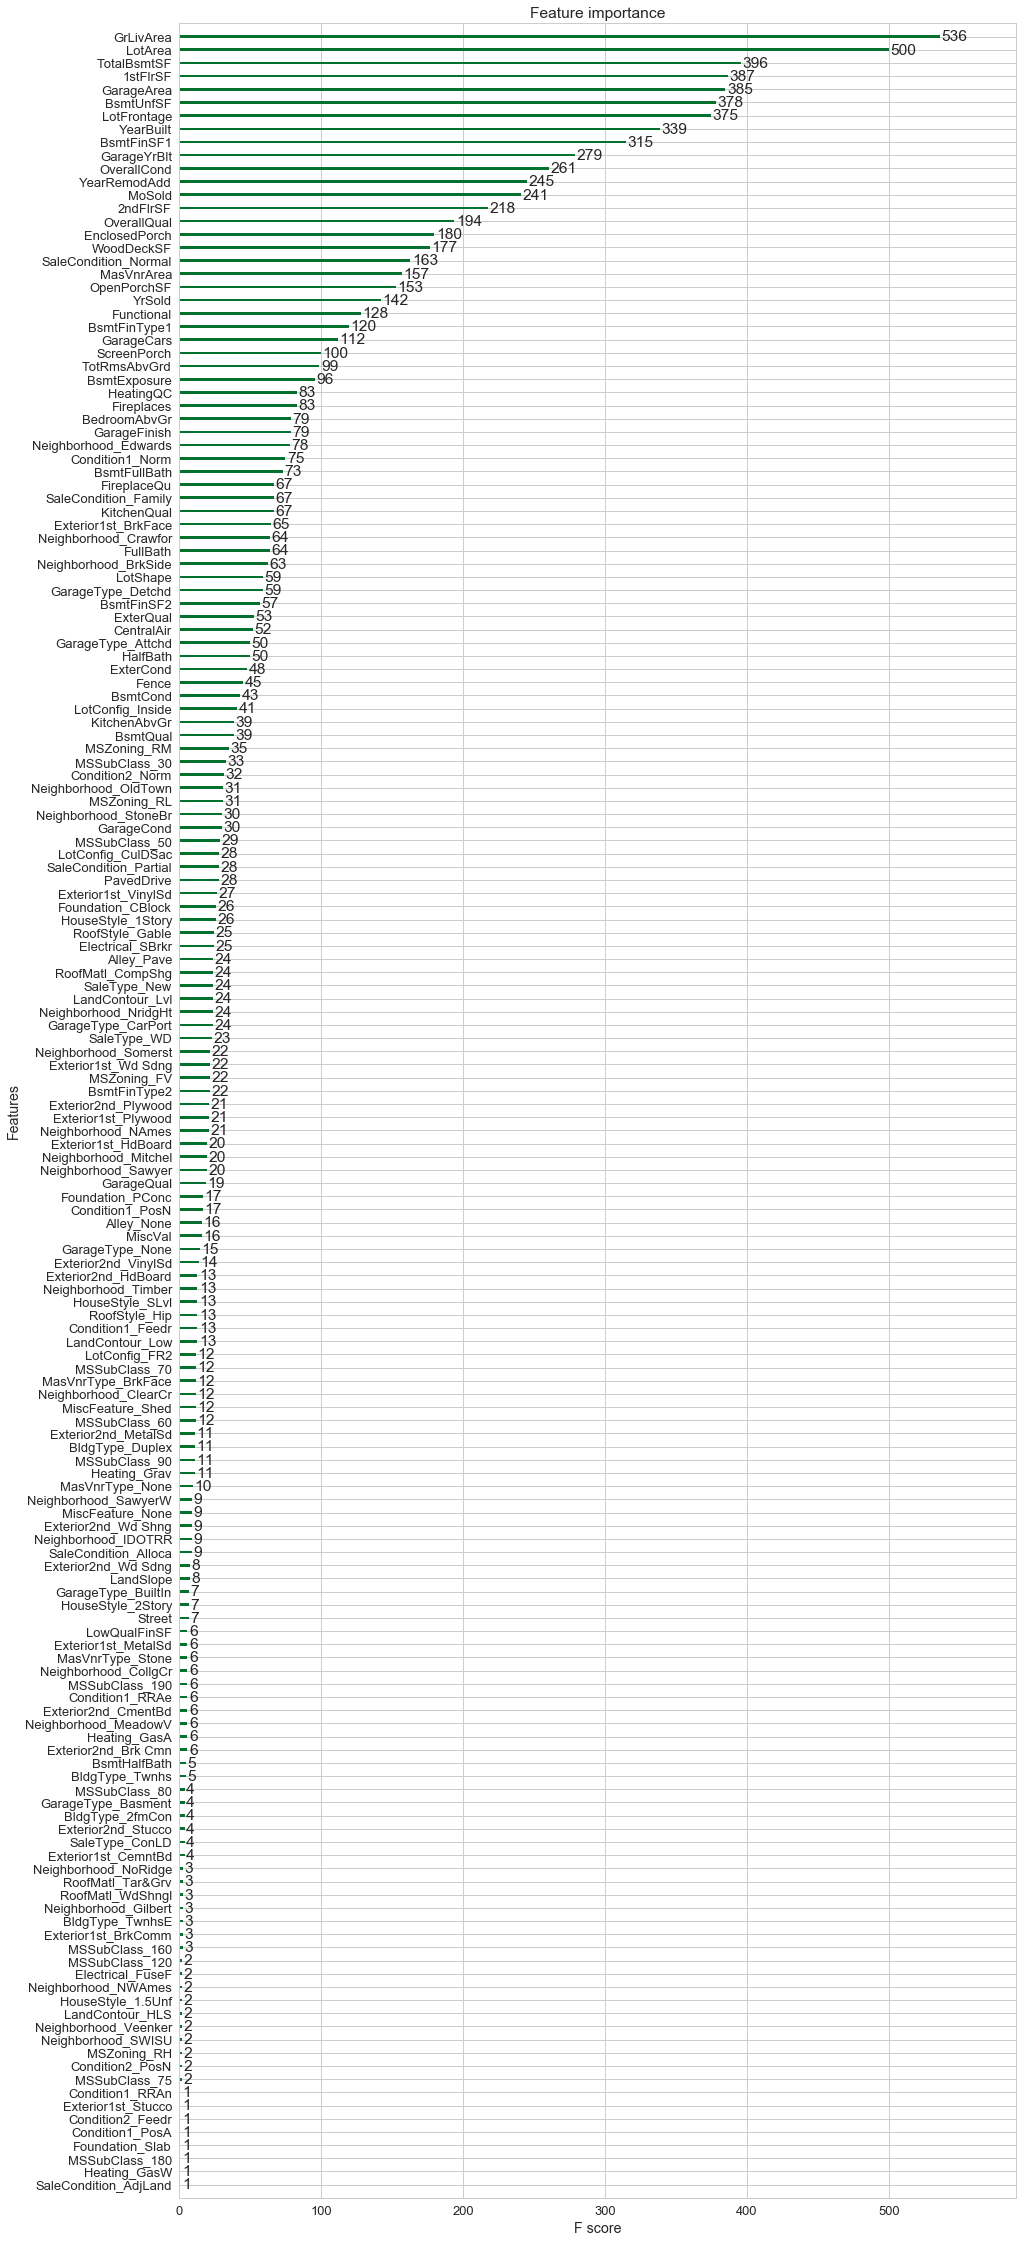

In [132]:
from xgboost import plot_importance
ax = plot_importance(model_xgb)
fig = ax.figure
fig.set_size_inches(15, 40)

### Lasso

In [189]:
from sklearn.linear_model import Lasso

################# PIPELINE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

dataset = train
features = train.drop(columns=['Id', 'SalePrice'])
target =  train['SalePrice'].values

lasso = make_pipeline(MinMaxScaler(), Lasso(alpha =0.0005, random_state=0))
print("CV: ", np.mean(np.sqrt(-cross_val_score(lasso, features, target, scoring="neg_mean_squared_error", cv = 100))))


from sklearn.metrics import mean_squared_error
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]

lasso.fit(features, target)

lassoPred = np.sqrt(mean_squared_error(np.log1p(target2), lasso.predict(test.drop(columns=["Id"]))))

print("Lasso prediction:", lassoPred)

CV:  0.09971028592687395
Lasso prediction: 0.19115583937156982


## ElasticNet

In [190]:
from sklearn.linear_model import ElasticNet

dataset = train
features = train.drop(columns=['Id', 'SalePrice'])
target =  train['SalePrice'].values

en = make_pipeline(MinMaxScaler(), ElasticNet(alpha=0.0001, l1_ratio=1.5, random_state=0))
print("CV: ", np.mean(np.sqrt(-cross_val_score(en, features, target, scoring="neg_mean_squared_error", cv = 100))))
from sklearn.metrics import mean_squared_error
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]

en.fit(features, target)

enPred = np.sqrt(mean_squared_error(np.log1p(target2), en.predict(test.drop(columns=["Id"]))))

print("EN prediction:", enPred)

CV:  0.09837216099406161
EN prediction: 0.19628927463674706


## KernelRidge

In [191]:
from sklearn.kernel_ridge import KernelRidge

dataset = train
features = train.drop(columns=['Id', 'SalePrice'])
target =  train['SalePrice'].values

#kr = KernelRidge(alpha=0.005, kernel='polynomial', degree=1, coef0=1)
kr = make_pipeline(MinMaxScaler(), KernelRidge(alpha=0.02, kernel='polynomial', degree=1, coef0=1))
print("CV: ", np.mean(np.sqrt(-cross_val_score(kr, features, target, scoring="neg_mean_squared_error", cv = 100))))
from sklearn.metrics import mean_squared_error
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]

kr.fit(features, target)

krPred = np.sqrt(mean_squared_error(np.log1p(target2), kr.predict(test.drop(columns=["Id"]))))

print("KRR prediction:", krPred)

CV:  0.100672891820922
KRR prediction: 0.18511163802635747


## LightGBM

In [126]:
import lightgbm

lgb = lightgbm.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=0,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [127]:
from sklearn.metrics import mean_squared_error

lgb.fit(features, target)

# open train2 and get 1201 -> 1460
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]
# drop id and saleprice
# call test2
#print("CV: ", np.mean(np.sqrt(-cross_val_score(lgb, features, target, scoring="neg_mean_squared_error", cv = 10))))
lgbPred = lgb.predict(test.drop(columns=["Id"]))
lgbErr = np.sqrt(mean_squared_error(np.log1p(target2), lgbPred))

print("LGBoost prediction:", lgbErr)

LGBoost prediction: 0.13498801960619852


## Gradient Boosting

In [273]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=4, min_samples_split=8, 
                                   loss='ls', random_state = 1)

In [274]:
from sklearn.metrics import mean_squared_error

gb.fit(features, target)

# open train2 and get 1201 -> 1460
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]
# drop id and saleprice
# call test2
#print("CV: ", np.mean(np.sqrt(-cross_val_score(gb, features, target, scoring="neg_mean_squared_error", cv = 10))))
gbPred = gb.predict(test.drop(columns=["Id"]))
gbErr = np.sqrt(mean_squared_error(np.log1p(target2), gbPred))

print("GBoost prediction:",  gbErr)

GBoost prediction: 0.12809905481745706


## StackingRegressor

In [192]:
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

svr = SVR(kernel='rbf', C=1)
stackRegr = make_pipeline(MinMaxScaler(), StackingRegressor(regressors=[en, kr, lasso], meta_regressor=svr))
stackRegr.fit(features, target)
stackedPred = stackRegr.predict(test.drop(columns=["Id"]))
stackedError = np.sqrt(mean_squared_error(np.log1p(target2), stackedPred))

print("Stacked prediction:",  stackedError)

#np.mean(np.sqrt(-cross_val_score(stackRegr, features, target, scoring="neg_mean_squared_error", cv = 100)))

Stacked prediction: 0.1108127336410472


In [367]:
svr2 = SVR(kernel='rbf', C=0.5)
stackRegr2 = StackingRegressor(regressors=[gb, lgb, pipeline], meta_regressor=svr2)
stackRegr2.fit(features, target)
stackedPred2 = stackRegr2.predict(test.drop(columns=["Id"]))
stackedError2 = np.sqrt(mean_squared_error(np.log1p(target2), stackedPred2))

print("Stacked prediction:",  stackedError2)
#np.mean(np.sqrt(-cross_val_score(stackRegr2, features, target, scoring="neg_mean_squared_error", cv = 100)))

Stacked prediction: 0.11752474702937693


## Ensamble predictions

<div class='alert alert-success'>
The idea is to aggregate together the "simple" models with a stacked regressor, and then compose the final prediction with the complex models like XGBoost and LGBoost.<br>
The hyperparameters are found thanks to Bayesian Optimization:
</div>

In [198]:
# ensemblePred = stackedPred * 0.65 + xgbPred * 0.2 + stackedPred2 * 0.15
ensemblePred = stackedPred * 0.75 + xgbPred * 0.25
np.sqrt(mean_squared_error(np.log1p(target2), ensemblePred))

0.10892791375743215

##### 6. Submission

In [128]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = submission
sub.to_csv('submission.csv',index=False)

NameError: name 'submission' is not defined

In [ ]:
submission = np.expm1(model_xgb.predict(test.drop(columns='Id')))

0.2540